## Time Series Analysis and Forecasting
### Assignment 02

Consider the Nile rive flow for 100 years.<br>
a)Is the data stationary?<br>
b)Split the data into train and test(last 10 years). Train an appropriate ARIMA model to forecast the flow<br>
c)What is the order of the ARIMA model.<br>
d)Compare the forecast with the actual<br>

<AxesSubplot:>

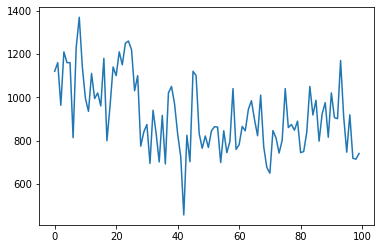

In [35]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import statsmodels.api as sm

nile_df = sm.datasets.nile.load_pandas()
nile_df.data['volume'].plot()

### Solution:

#### a) Is the data stationary?

In [36]:
#Stationarity Check - Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

flow = nile_df.data['volume']

adftest = adfuller(flow, autolag='AIC')
dfoutput=pd.Series(adftest[0:4],
                   index=['Test Statistic','p-value','#lags','#observations'])
print(dfoutput)

Test Statistic    -4.048705
p-value            0.001176
#lags              1.000000
#observations     98.000000
dtype: float64


#### Conclusion: Since p-value < 0.05, we reject the null hypothesis that time series is non-stationary.

#### b) Split the data into train and test(last 10 years).Train an appropriate ARIMA model to forecast the flow.

In [37]:
train = flow[:-10]      
test = flow[-10:]

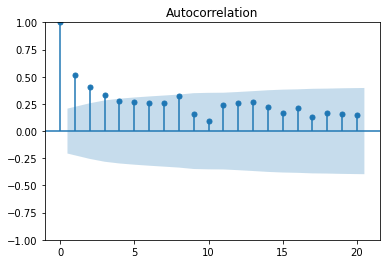

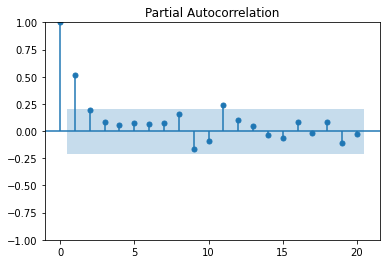

In [38]:
#ACF and PACF plots to identify model order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_res = plot_acf(train)
pacf_res = plot_pacf(train, method='ywm')

#### Based on the PACF plot, p = 1. We can try Q= 0 and 1. Since the data is stationary we don't need to diference it. 

In [39]:
from pmdarima.arima import auto_arima


sa_model = auto_arima(train, 
                      start_p=1, start_q=0,
                      max_p=2, max_q=2,
                      seasonal=False,
                      stationary=True,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1158.098, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1184.318, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1167.887, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1489.649, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1156.566, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1158.294, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1154.982, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1158.679, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1162.770, Time=0.12 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1160.308, Time=0.07 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.078 seconds


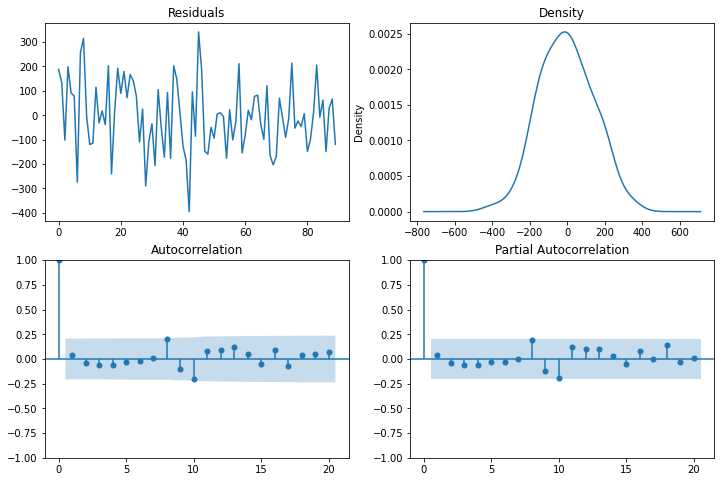

In [40]:
# Let's check the Residual Plots 
residuals = sa_model.resid()

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
residuals.plot(title='Residuals', ax=ax[0][0])
residuals.plot(title='Density', kind='kde', ax=ax[0][1])
plot_acf(residuals, ax=ax[1][0])
plot_pacf(residuals, method='ywm', ax=ax[1][1])
plt.show()

The residual plot has no autocorrelation and errors seem to be normally distributed.

#### c) What is the order of the ARIMA model.

The model order is ARIMA(1,0,1)

#### d) Compare the forecast with the actual

In [41]:
forecast = sa_model.predict(n_periods=test.shape[0])

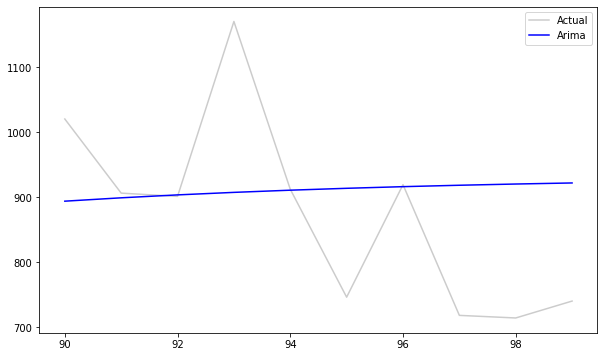

In [42]:
# Visual comparison
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(test, color='.8', label='Actual')
ax.plot(forecast, color='b', label='Arima')
ax.legend()

In [43]:
# Calculate MAPE 
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

print(f'MAPE = {mean_absolute_percentage_error(test,forecast)}')

MAPE = 0.1401107269742839


***